# Advances in Data Mining - Assignment 3
## Visualization tasks
----------------------------------------------------

In [1]:
# Import
from scipy.stats import uniform, randint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import numpy as np
import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, r2_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE

The purpose of this assignment is to demonstrate capability of three algorithms for
dimensionality reduction and data visualization: PCA, LLE and t-SNE.

## Data Description
In this assignment we will be using the same credit card fraud dataset as used in the first notebook on classification tasks. 

In [2]:
credit = pd.read_csv('creditcard.csv')

## Principle Component Analysis (PCA)
PCA is used to extract information from high-dimensional data by projecting it into a lower dimension. This can be useful for speeding machine learning algorithms up, or visualizing data. We will use this to visualize our dataset. 

In [3]:
# We start by standardizing the data since PCA is influenced by the scale of the features

y = credit['Class'].values
X = credit.drop(['Class'], axis=1).values
X = StandardScaler().fit_transform(X)

In [4]:
# 2d PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principal_df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
print(principal_df.shape)

(284807, 2)


In [5]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.06527313 0.05610663]


Text(0, 0.5, 'Principal Component 2')

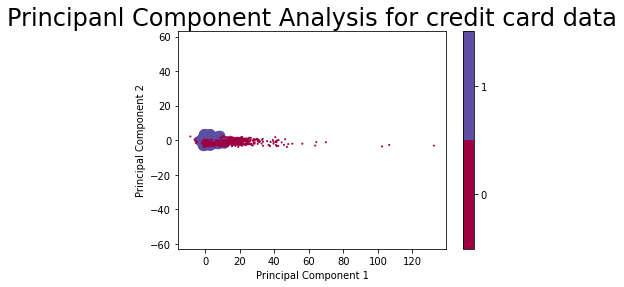

In [6]:
#PCA Visualization

# I need to make the size of scatters of fraudulant cases larger since they are under-represented in the dataset
# So this does not mean that there are more cases there
s = []
for i in y:
    if i == 0:
        s.append(1)
    else:
        s.append(100)

plt.scatter(principalComponents[:, 0], principalComponents[:, 1], s=s, c=y, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('Principanl Component Analysis for credit card data', fontsize=24);
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

From this information, we can see that the first two principal components hardly explain much of the variance in the data. Combined they only contain 12.14% of the information!

## Linear Local Embedding (LLE)
LLE is a method of non-linear dimensionality reduction. It first finds the k-nearest neighbors of the data points, then approximates each vector of data as a weighted linear combination of its k-nearest neighbors. Lastly, it computes the weights that best reconstruct the vectors from its neighbors, then produce the low-dimensional vectors best reconstructed by these weights.

In [145]:
# See below why I added this instead of the original dataset
fraud_df = credit[credit['Class'] == 1]
nonfraud_df = credit[credit['Class'] == 0].sample(len(fraud_df) + 10000)
new_df_undersample = pd.concat([fraud_df, nonfraud_df]).sample(frac=1)

y = new_df_undersample['Class'].values
X = new_df_undersample.drop(['Class'], axis=1).values

In [146]:
standardized = StandardScaler().fit_transform(X)
standardized.shape

(10984, 30)

In [147]:
# LLE in 2D
LLE = LocallyLinearEmbedding(n_components=2)
LLE

LocallyLinearEmbedding()

In [148]:
#This took too long!!! Therefore I went back and took the undersample - plus a number - from the classification notebook
# In this way we have more balanced datapoints and we can actually run this visualization in a normal amount of time.
LLE_transformed = LLE.fit_transform(standardized)

In [149]:
LLE_stack = np.vstack((LLE_transformed.T, y)).T
LLE_stack

array([[-0.01001332, -0.00908293,  0.        ],
       [-0.00278893, -0.00312191,  0.        ],
       [-0.00125651, -0.00237053,  0.        ],
       ...,
       [ 0.02047173, -0.04501249,  0.        ],
       [-0.000958  , -0.00418069,  0.        ],
       [-0.00023982,  0.00319565,  0.        ]])

In [150]:
print("Reconstruction error: %g" % LLE.reconstruction_error_)
LLE_df = pd.DataFrame(data=LLE_stack, columns=('Dimension 1', 'Dimension 2', 'Label'))

Reconstruction error: 2.57175e-17


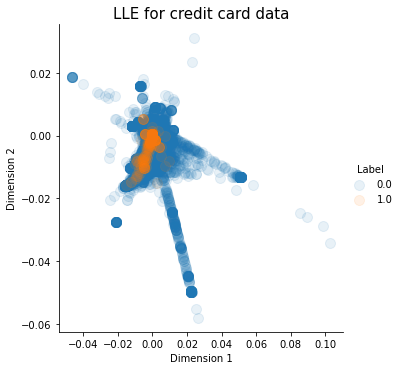

In [151]:
sns.FacetGrid(LLE_df, hue='Label', height=5).map(plt.scatter, 'Dimension 1', 'Dimension 2', s=100, alpha=.1).add_legend()
plt.title('LLE for credit card data', fontsize=15);
plt.show()

There seems to be quite some overlap between fraudulant and genuine points. We find that the reconstruction error is 2.57175e-17. As mentioned in the comments before, a sample of the data was taken so that LLE could run in a reasonable amount of time. Increasing this sample  will increase the number of genuine (label = 0) cases and might give a more accurate picture of what is happening. 

## t-distributed Stochastic Neighbor Embedding (t-SNE)
t-SNE is another dimensionality reduction technique, which mainly consists of 2 stages. The first step is to construct a probability distribution over pairs of high-dimensional objects so that similar object are assigned a higher probability. Then in the second step, another probability distribution is created over the points in a lower dimension, which then leads to it minimizing the divergence between these two probability distributions.

In [7]:
# Again, it took too long to run and therefore had to limit the dataset on genuine cases.
fraud_df = credit[credit['Class'] == 1]
nonfraud_df = credit[credit['Class'] == 0].sample(len(fraud_df) + 10000)
new_df_undersample = pd.concat([fraud_df, nonfraud_df]).sample(frac=1)

y = new_df_undersample['Class'].values
X = new_df_undersample.drop(['Class'], axis=1).values
X = StandardScaler().fit_transform(X)

C:\Users\Jasmin\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


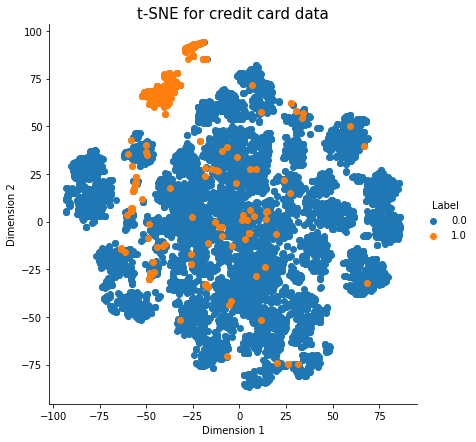

In [8]:
#t-SNE
tsne = TSNE(n_components=2, random_state=10)

tsne_data = tsne.fit_transform(X)
tsne_data = np.vstack((tsne_data.T, y)).T

tsne_df = pd.DataFrame(data=tsne_data, columns=('Dimension 1', 'Dimension 2', 'Label'))
sns.FacetGrid(tsne_df, hue='Label', size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title('t-SNE for credit card data', fontsize=15);
plt.show()

t-SNE gives a bit of a clearer picture compared to the other two visualization algorithms. Whilst there is still overlapp between fraudulant and genuine cases, there is a clearer distinction between the two classes that we see here. A mentioned above, because t-SNE runs too long when the number of feaures is high, we decided to take a more represented sample of the data. Another approach to decreasing running time is to first run another dimensionality reduction algorithm (i.e. PCA) before running t-SNE. In this way, we reduce the number of dimensions to a reasonable amount that t-SNE can handle.

## Sources used:

- https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
- https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python
- https://medium.com/analytics-vidhya/locally-linear-embedding-lle-data-mining-b956616d24e9
- https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b